# Analysis of the QM7 dataset


*Taken from:* https://www.kaggle.com/code/mjmurphy28/predicting-atomization-energy-qm7/notebook

*Original website:* http://quantum-machine.org/datasets/

**Attributes:**

- X: (7165 x 23 x 23), Coulomb matrices, low-level molecular descriptor (Rupp et al., 2012)
- T: (7165), atomization energies (unit: kcal/mol)
- P: (5 x 1433), cross-validation splits as used in [Montavon et al. NIPS, 2012]
- Z: (7165 x 23), atomic charges
- R: (7165 x 23 x 3), cartesian coordinate (unit: Bohr) of each atom in the molecules


I.e. it contains 23 atoms and 7165 molecules.

They say 'The Coulomb matrix has built-in invariance to translation and rotation of the molecule', because it is calculated by:

$$C_{ii} = \frac{1}{2} Z_i^{2.4} \text{ and } C_{ij} = \frac{Z_i Z_j}{|R_i - R_j|}$$

where $Z_i$ is the nuclear charge of atom $i$ and $R_i$ is its position. Thus translation and rotation of a molecule (the atoms positions) will not change the value of $C$.


In [41]:
import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import torch
import os
from sklearn.preprocessing import StandardScaler
import pylab 
import scipy.stats as stats
plt.style.use('ggplot')

rand_state = 42

np.random.seed(rand_state)

In [3]:
path = os.getcwd() 
path = path[:path.rfind(os.sep)]

In [4]:
os.chdir('../')
from modules.Datasets import QM7_dataset, get_loaders

In [5]:
# full dataset
data = f'{os.sep}data{os.sep}QM7{os.sep}qm7.mat'
data_path = path+data
dataset = QM7_dataset(path=data_path, device='cpu')

# Construct loaders
graph_info, graph_data = dataset
# you can adjust the test and val size here
loaders = get_loaders(graph_info, graph_data, batch_size=32, test_size=0.2, val_size=0.2,
                      device=torch.device('cpu'), random_state=0, shuffle=True)



100%|██████████████████████████████████████| 7165/7165 [00:29<00:00, 242.59it/s]


In [6]:
train_loader, val_loader, test_loader = tuple(loaders.values())

In [26]:

# values for histograms

check_list = ['target', 'num_nodes', 'edge_lengths', 'edge_coulomb']
data_dict = {check: np.array([]) for check in check_list}

for idx_batch, train_batch in enumerate(train_loader):
    for check in check_list:
        check_item = getattr(train_batch, check)
        try:
            data_dict[check] = np.extend(data_dict[check], check_item.numpy())
        except Exception:
            data_dict[check] = np.append(data_dict[check], check_item)
        #print(check)
        #print(check_item)
        #print('\n')


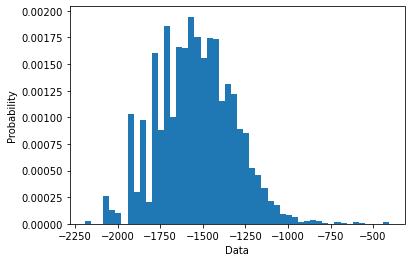

In [32]:
plt.hist(data_dict['target'], density=True, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');
plt.show()

In [52]:
np.random.normal(0,1,len(data_dict['target']))

array([ 1.46564877, -0.2257763 ,  0.0675282 , ..., -2.1715714 ,
       -0.0081132 ,  0.15808923])

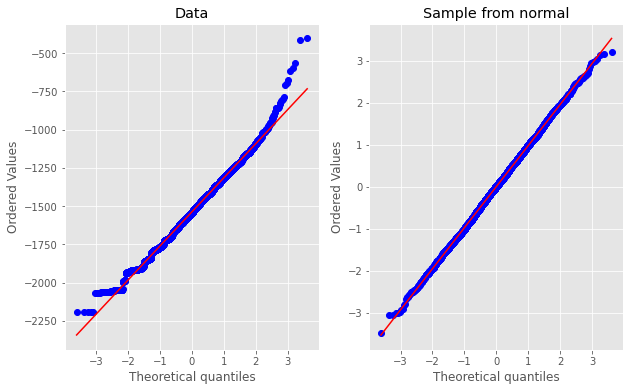

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))
#fig(figsize=(8, 6), dpi=80)

stats.probplot(data_dict['target'], dist="norm", plot=ax1);
ax1.title.set_text('Data')

stats.probplot(np.random.normal(0,1,len(data_dict['target'])), dist="norm", plot=ax2);
ax2.title.set_text('Sample from normal')

plt.show()


Seems like target can be standardize and not normalized?

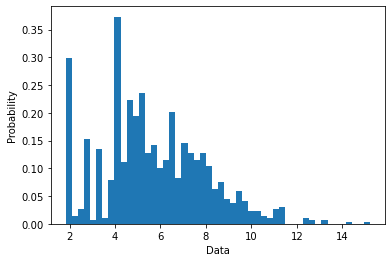

In [13]:
plt.hist(np.array(data_dict['edge_lengths'][:1000]), density=True, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');
plt.show()

In [ ]:
plt.hist(data_dict['edge_coulomb'], density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');
plt.show()

In [ ]:
# missing analysis
['node_from', 'node_to', 'node_graph_index']

In [37]:
data_dict['target'].reshape(-1, 1).shape

(4576, 1)

### standardization

In [40]:

print(data_dict['target'].reshape(-1, 1)[:5])

scalar = StandardScaler()
# standardization of dependent variables
scaled = scalar.fit_transform(data_dict['target'].reshape(-1, 1)) 

print(scaled[:5])

unscaled = scalar.inverse_transform(scaled)
print(unscaled[:5])


[[-1688.27001953]
 [-1853.34997559]
 [-1230.06005859]
 [-1155.34997559]
 [-1935.64001465]]
[[-0.673729  ]
 [-1.41391848]
 [ 1.38080386]
 [ 1.71579073]
 [-1.78289254]]
[[-1688.27001953]
 [-1853.34997559]
 [-1230.06005859]
 [-1155.34997559]
 [-1935.64001465]]


---

# Getting QM7 ready for dataloaders

In [46]:
# coulomb matrix of first molecule

qm7['X'][0][:5,:5]

array([[36.858105  ,  2.9076326 ,  2.907612  ,  2.9075644 ,  2.9053485 ],
       [ 2.9076326 ,  0.5       ,  0.29672   ,  0.29671896,  0.2966784 ],
       [ 2.907612  ,  0.29672   ,  0.5       ,  0.29671845,  0.29667813],
       [ 2.9075644 ,  0.29671896,  0.29671845,  0.5       ,  0.29667678],
       [ 2.9053485 ,  0.2966784 ,  0.29667813,  0.29667678,  0.5       ]],
      dtype=float32)

In [48]:
# atom energies (see periodic table)
#    - from here we see it consists of CH4 (which is methane)
# note: this ordering varies per molecule
qm7['Z'][0][:5]

array([6., 1., 1., 1., 1.], dtype=float32)

### formatting the dataset to Datasets.py

In [18]:
print('total atoms with charges: ', (qm7['Z']>0).sum())
print('total atoms with coordinates: ', ((qm7['R']**2).sum(axis=2)>0).sum())
# the same thus former can be used from self.num_nodes

total atoms with charges:  110650
total atoms with coordinates:  110650


In [3]:
# it needs the following attributes

# GRAPH/MOLECULE RELATED:

# Number of graphs in the dataset, i.e. molecules
num_graphs = len(qm7['T'][0]) # T is atomization energies (target)

# Graph list, each molecule has a
graph_list = torch.tensor(range(num_graphs))

# the energy of each molecule
molecule_energy = torch.tensor(qm7['T'][0])

# NODE/ATOM RELATED:

# i.e. atoms, each atom will be distinct
# total charges higher than 0 (there are no negative and 0 charged atoms, see above)
num_nodes = int((qm7['Z']>0).sum())

node_list = torch.tensor(range(num_nodes))

# Node graph index, molecule number each atom belongs to
node_graph_index = []

# Node coordinates
node_coordinates = []

# Node atomic charge
node_charge = [0]*num_nodes # currently empty


# EDGE RELATED:

# Edge list - fully conected graphs due to 
edge_list = []

# the coulomb value for each edge
edge_coulomb = []


# keeping note of atom indices globally (i.e. for all graphs and w.r.t. num_nodes)
global_idx = 0
# looping each molecule
for molecule in graph_list:
    
    # each nodes index in current graph (globally)
    nodes_idx_graph = [local_idx + global_idx for local_idx in list(range((qm7['Z'][molecule]>0).sum()))]
    
    # looping each atom/node in current molecule
    for node_idx in range((qm7['Z'][molecule]>0).sum()) :
        node_graph_index.append(molecule) # saving which molecule this atom belongs to
        node_coordinates.append(qm7['R'][molecule][node_idx]) # saving nodes/atoms coordinate
        node_charge[global_idx] = qm7['Z'][molecule][node_idx] # saving each nodes/atoms energy
        
        # looping all neighbouring nodes/atoms in graph/molecule (based on global node index)
        # creating edge list, note: fully connected
        for idx, neighbouring_node in enumerate(nodes_idx_graph):
            # if not current atom_idx (don't want edges going to themselvel)
            if neighbouring_node != global_idx:
                # creating the edge list
                edge_list.append([global_idx, neighbouring_node])
                # coulomb value per edge, note: symmetric
                edge_coulomb.append(qm7['X'][molecule][node_idx, idx])
        
        global_idx += 1

assert num_nodes == global_idx, 'inconsistencies noticed'


#self.node_graph_index = torch.tensor(node_coordinates)

#self.node_coordinates = torch.tensor(node_coordinates)

#self.node_charge = torch.tensor(node_charge)

#self.edge_list = torch.tensor(edge_list)

#self.edge_coulomb = torch.tensor(edge_coulomb)

# For training and batching

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

In [12]:
batch_size=64
test_size=0.2
val_size=0.2
random_state=42
shuffle=True

In [14]:
train_data, test_data = train_test_split(graph_list, test_size=test_size, random_state=random_state,shuffle=shuffle)

In [9]:
graph_list

tensor([   0,    1,    2,  ..., 7162, 7163, 7164])

in til train.py script